## Inference

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from crackseg.models import UNet
from inference import preprocess
from io import BytesIO
import os
# from crackseg.utils.dataset2 import CrackAugment

import crackseg.utils.augmentation
from crackseg.utils.dataset2 import CrackAugment

In [2]:
# Load model weights

model_weight = "../weights/finetuned-all-occlude.pt"
# model_weight = "../weights/finetuned-all-occlude-color.pt"
# model_weight = "../weights/pretrained.pt"

# Load weight
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(model_weight, map_location=device)

# Initialize model and load checkpoint
model = UNet(in_channels=3, out_channels=2)
model.load_state_dict(checkpoint["model"].float().state_dict())

<All keys matched successfully>

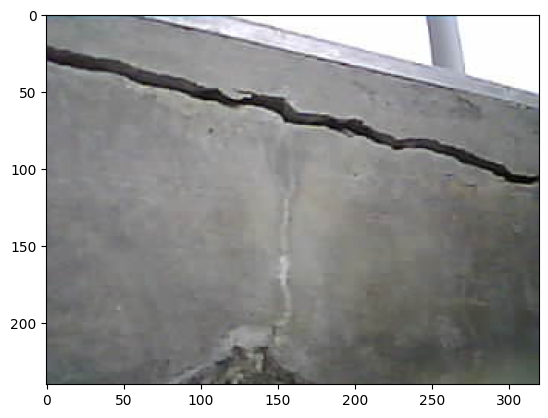

In [30]:
import requests
input_path = "http://192.168.137.253/capture"

# get from file

response = requests.get(input_path)
input_image = Image.open(BytesIO(response.content))
# Display the image
plt.imshow(input_image)
plt.show()

# Save the image
output_path = "../data/captured/image1.jpg"  # replace with your desired path
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

input_image.save(output_path)

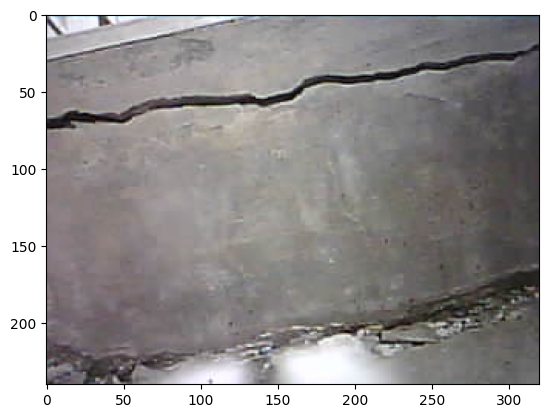

In [36]:
import requests
input_path = "http://192.168.137.34/capture"

# get from file

response = requests.get(input_path)
input_image = Image.open(BytesIO(response.content))
# Display the image
plt.imshow(input_image)
plt.show()

# Save the image
output_path = "../data/captured/image2.jpg"  # replace with your desired path
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

input_image.save(output_path)

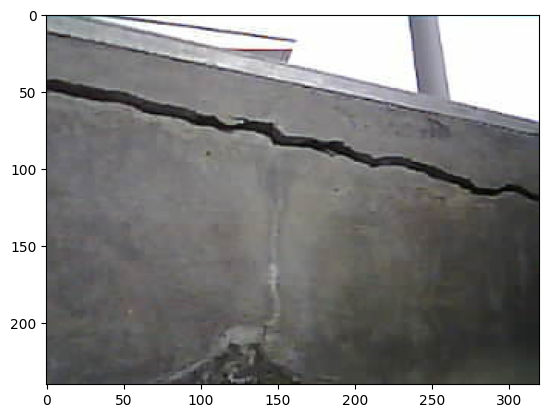

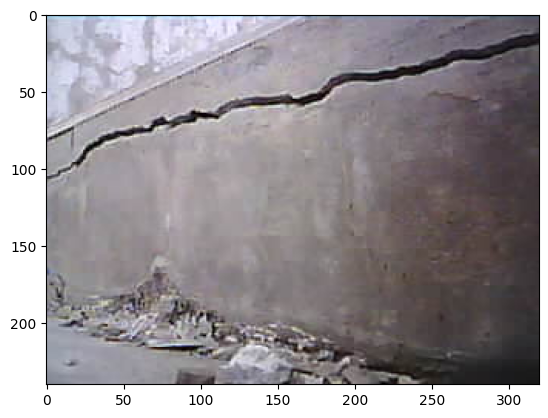

In [40]:
import requests
input_path = "http://192.168.137.242/capture"

# get from file

response = requests.get(input_path)
input_image = Image.open(BytesIO(response.content))
# Display the image
plt.imshow(input_image)
plt.show()

# Save the image
output_path = "../data/captured/image31.jpg"  # replace with your desired path
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

input_image.save(output_path)

In [27]:
# Offset prediction threshold, more positive predicts crack label more. often
SENSITIVITY = -10

model.eval()
model.to(device)

# inference
with torch.no_grad():
    output = model(tensor_image).cpu()
    # output = output.argmax(dim=1)
    output = output[:,0,:,:] < output[:,1,:,:] + SENSITIVITY

mask = output[0].long().squeeze().numpy()

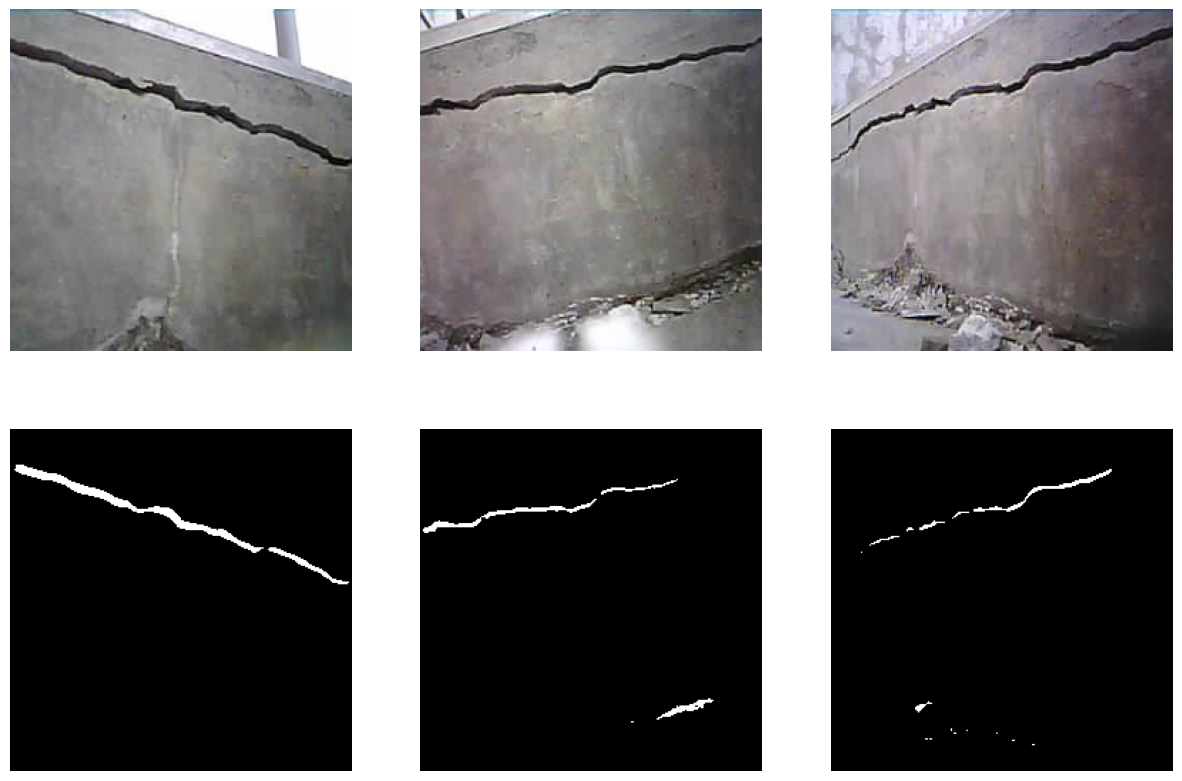

In [41]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from crackseg.models import UNet
from inference import preprocess

# Load model weights
model_weight = "../weights/finetuned-all-occlude.pt"

# Load weight
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(model_weight, map_location=device)

# Initialize model and load checkpoint
model = UNet(in_channels=3, out_channels=2)
model.load_state_dict(checkpoint["model"].float().state_dict())

# Offset prediction threshold, more positive predicts crack label more often
SENSITIVITY = -10

model.eval()
model.to(device)

# Define the paths of the three input images
input_paths = ["../data/captured/image1.jpg", 
               "../data/captured/image2.jpg", 
               "../data/captured/image31.jpg"]

# Initialize lists to store the input images and masks
input_images = []
masks = []

# Process each input image
for input_path in input_paths:
    # Load the input image
    input_image = Image.open(input_path).convert('RGB')
    input_image = input_image.resize((240, 240))
    tensor_image = torch.from_numpy(preprocess(input_image, is_mask=False))
    tensor_image = tensor_image.unsqueeze(0)
    tensor_image = tensor_image.to(device, dtype=torch.float32)

    # Perform inference
    with torch.no_grad():
        output = model(tensor_image).cpu()
        output = output[:,0,:,:] < output[:,1,:,:] + SENSITIVITY

    # Store the input image and mask
    input_images.append(np.moveaxis(np.squeeze(np.array(tensor_image.cpu())), 0, 2))
    masks.append(output[0].long().squeeze().numpy())

# Create a figure with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Display the input images and masks
for i in range(3):
    axs[0, i].imshow(input_images[i])
    axs[0, i].axis('off')
    axs[1, i].imshow(masks[i], cmap='gray')
    axs[1, i].axis('off')

# Show the figure
plt.show()


File uploaded successfully


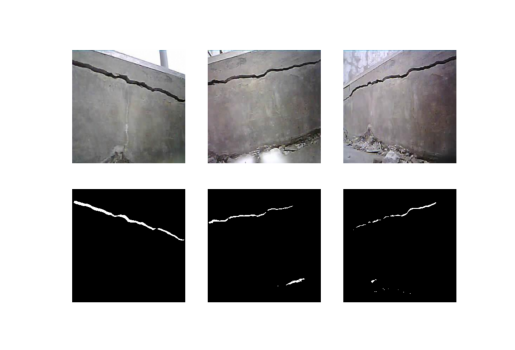

In [42]:
import io
import requests
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Assuming 'fig' is the figure object containing your plot
fig.canvas.draw()

# Get ARGB image
canvas_data = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)

# Reshape and reorder to RGBA
canvas_data = canvas_data.reshape(fig.canvas.get_width_height()[::-1] + (4,))
canvas_data = np.roll(canvas_data, -1, axis=-1)

# Create image
image = Image.fromarray(canvas_data)

# Save the image locally
image.save("result.png")

# Convert the image to bytes
buf = io.BytesIO()
image.save(buf, format='PNG')
image_bytes = buf.getvalue()

# Send the image to the Flask server
url = 'http://localhost:5000/upload'
response = requests.post(url, files={'file': ('result.png', image_bytes, 'image/png')})

print(response.text)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()
